# Image Processing Project

## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2

from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    jaccard_score,
)

In [2]:
def calculate_metrics(true: np.ndarray, pred: np.ndarray) -> dict[str, float]:
    true, pred = true.ravel(), pred.ravel()
    # tn, fp, fn, tp = confusion_matrix(true, pred).ravel()
    accuracy = accuracy_score(true, pred)
    precision = precision_score(true, pred, pos_label=255)
    sensitivity = recall_score(true, pred, pos_label=255)
    specificity = recall_score(true, pred, pos_label=0)
    f1 = f1_score(true, pred, pos_label=255)
    iou = jaccard_score(true, pred, pos_label=255)

    return pd.Series(
        {
            # "tp": tp,
            # "tn": tn,
            # "fp": fp,
            # "fn": fn,
            "accuracy": accuracy,
            "precision": precision,
            "sensitivity": sensitivity,
            "specificity": specificity,
            "f1": f1,
            "iou": iou,
        }
    )

## All Images

In [3]:
all_image_names = [f"{year}_{i:02d}" for i in range(1, 11) for year in (2014, 2016, 2018)]
all_image_names[:5]

['2014_01', '2016_01', '2018_01', '2014_02', '2016_02']

In [4]:
results1 = []
for image_name in all_image_names:
    image = cv2.imread(f"../data/images/{image_name}.png")
    gt = cv2.cvtColor(cv2.imread(f"../data/gt/{image_name}_gt.bmp"), cv2.COLOR_BGR2GRAY)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # eq = cv2.equalizeHist(gray)
    thresh, mask = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # if black blob: run algo 2

    cv2.imwrite(f"../data/results/1/{image_name}.png", mask)
    errors = calculate_metrics(mask, gt)
    errors["image"] = image_name
    results1.append(errors)

In [5]:
df_results1 = pd.DataFrame(results1)
df_results1 = df_results1[["image", *df_results1.columns[:-1]]]
df_results1.to_csv("../data/results/1.csv")

In [6]:
results2 = []
for image_name in all_image_names:
    image = cv2.imread(f"../data/images/{image_name}.png")
    gt = cv2.cvtColor(cv2.imread(f"../data/gt/{image_name}_gt.bmp"), cv2.COLOR_BGR2GRAY)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    clahe = cv2.createCLAHE(1)
    eq = np.clip(clahe.apply(gray), 0, 255).astype(np.uint8)
    denoized = cv2.GaussianBlur(eq, (9, 9), -1)
    thresholded = cv2.adaptiveThreshold(denoized, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 3)
    kernel_closing = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    kernel_opening = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    mask_closed = cv2.morphologyEx(thresholded, cv2.MORPH_CLOSE, kernel_closing, iterations=1)
    mask_opened = cv2.morphologyEx(mask_closed, cv2.MORPH_OPEN, kernel_opening, iterations=1)
    mask = cv2.medianBlur(mask_opened, 7)
    # save all the images
    cv2.imwrite(f"../data/results/2/{image_name}.png", mask)
    errors = calculate_metrics(mask, gt)
    errors["image"] = image_name
    results2.append(errors)

In [7]:
df_results2 = pd.DataFrame(results2)
df_results2 = df_results2[["image", *df_results2.columns[:-1]]]
df_results1.to_csv("../data/results/2.csv")

## Results

In [8]:
df_results1 = pd.read_csv("../data/results/1.csv")
df_results2 = pd.read_csv("../data/results/2.csv")

In [9]:
df_results1.describe()

,Unnamed: 0,accuracy,precision,sensitivity,specificity,f1,iou
count,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000
mean,14.500000,0.940145,0.947328,0.986864,0.754218,0.964278,0.935583
std,8.803408,0.085375,0.090151,0.009773,0.291539,0.054944,0.089289
min,0.000000,0.582675,0.570420,0.960834,0.087299,0.722592,0.565671
25%,7.250000,0.914984,0.909072,0.983132,0.614799,0.948876,0.902813
50%,14.500000,0.978301,0.993714,0.989470,0.906336,0.987423,0.975159
75%,21.750000,0.985936,0.997802,0.993966,0.973279,0.992362,0.984840
max,29.000000,0.996083,0.999905,0.997609,0.998756,0.997983,0.995974


In [10]:
df_results2.describe()

,Unnamed: 0,accuracy,precision,sensitivity,specificity,f1,iou
count,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000
mean,14.500000,0.940145,0.947328,0.986864,0.754218,0.964278,0.935583
std,8.803408,0.085375,0.090151,0.009773,0.291539,0.054944,0.089289
min,0.000000,0.582675,0.570420,0.960834,0.087299,0.722592,0.565671
25%,7.250000,0.914984,0.909072,0.983132,0.614799,0.948876,0.902813
50%,14.500000,0.978301,0.993714,0.989470,0.906336,0.987423,0.975159
75%,21.750000,0.985936,0.997802,0.993966,0.973279,0.992362,0.984840
max,29.000000,0.996083,0.999905,0.997609,0.998756,0.997983,0.995974


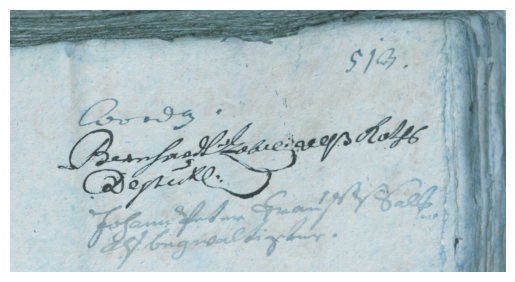

In [11]:
image_name = "2018_05"
image = cv2.imread(f"../data/images/{image_name}.png")
gt = cv2.cvtColor(cv2.imread(f"../data/gt/{image_name}_gt.bmp"), cv2.COLOR_BGR2GRAY)
plt.imshow(image)
plt.axis("off");

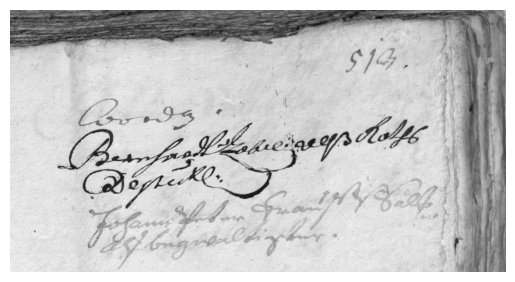

In [12]:
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
plt.imshow(gray, cmap="gray")
# plt.colorbar()
plt.axis("off");

## Algo 1

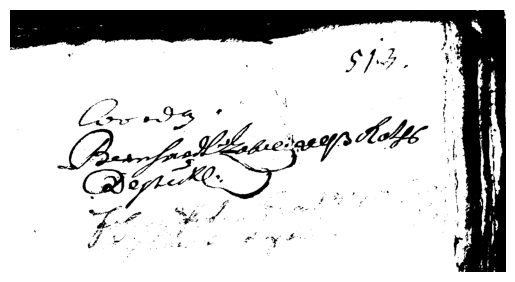

In [13]:
thresh, mask1 = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
plt.imshow(mask1, cmap="gray")
plt.axis("off");

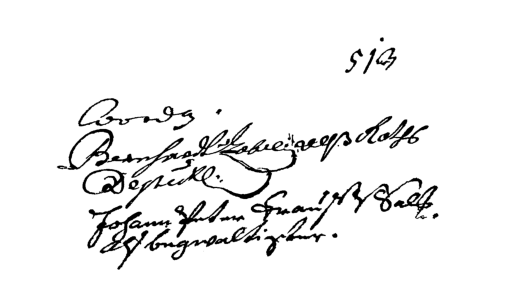

In [14]:
plt.imshow(gt, cmap="gray")
plt.axis("off");

## Algo 2

In [15]:
# eq = cv2.equalizeHist(gray)
# plt.imshow(eq, cmap="gray")
# plt.axis("off");

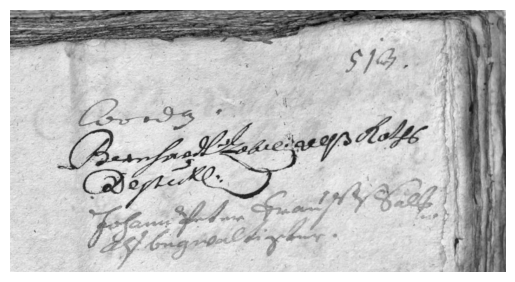

In [16]:
clahe = cv2.createCLAHE(1)
eq = np.clip(clahe.apply(gray), 0, 255).astype(np.uint8)
plt.imshow(eq, cmap="gray")
plt.axis("off");

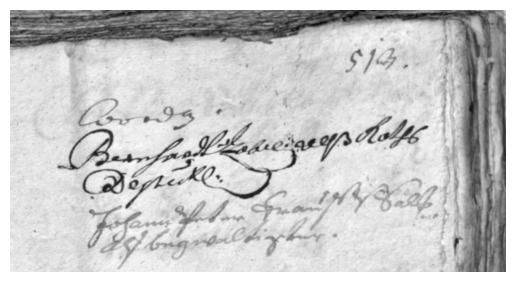

In [17]:
denoized = cv2.GaussianBlur(eq, (9, 9), -1)
plt.imshow(denoized, cmap="gray")
plt.axis("off");

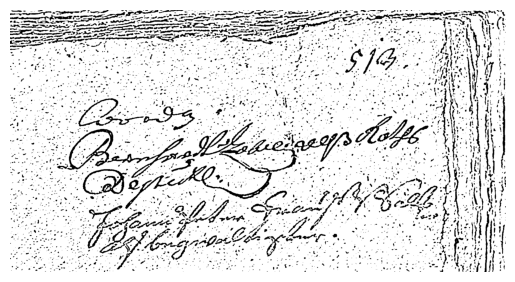

In [18]:
thresholded2 = cv2.adaptiveThreshold(denoized, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 3)
plt.imshow(thresholded2, cmap="gray")
plt.axis("off");

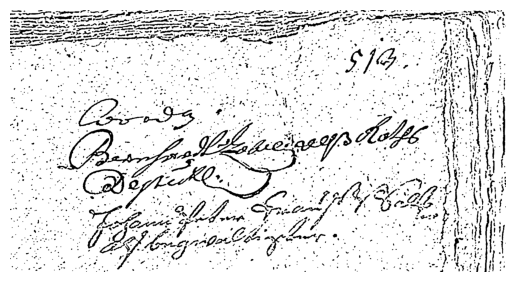

In [19]:
kernel_closing = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
kernel_opening = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
mask_closed = cv2.morphologyEx(thresholded2, cv2.MORPH_CLOSE, kernel_closing, iterations=1)
mask_opened = cv2.morphologyEx(mask_closed, cv2.MORPH_OPEN, kernel_opening, iterations=1)
plt.imshow(mask_opened, cmap="gray")
plt.axis("off");

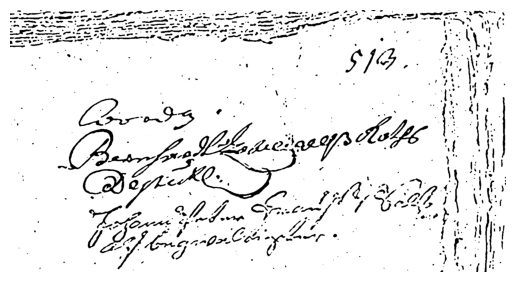

In [20]:
denoized_after = cv2.medianBlur(mask_opened, 7)
plt.imshow(denoized_after, cmap="gray")
plt.axis("off");

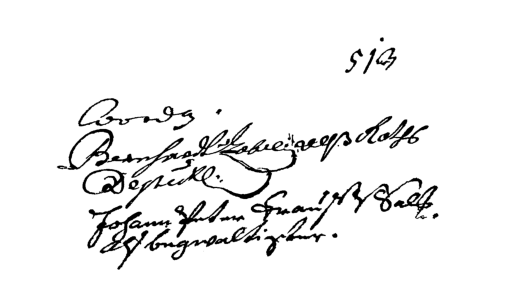

In [21]:
plt.imshow(gt, cmap="gray")
plt.axis("off");